In [1]:
import glob, os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from collections import Counter

from sklearn.svm import SVR, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import  metrics

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score


## Load datasets ##

In [35]:
from types import SimpleNamespace 

def load_dataset(path):
    dataset = np.load(path, allow_pickle=True)

    data = SimpleNamespace(X=dataset['X'], y=dataset['y'], meta=dataset['meta'])
    data.y_binary = np.where(data.y == None, 0, 1)  # 0 -> negative, 1 -> positive
    print(data.meta)
    
    return data

# train_data = load_dataset('ch1-2018-11-20_10-31-42_0000014.wav.npz')
train_data = load_dataset('ch1-2018-11-20_10-29-02_0000012.wav.npz')
test_data = load_dataset('ch1-2018-11-20_10-26-36_0000010.wav.npz')


{'audio_name': 'ch1-2018-11-20_10-29-02_0000012.wav', 'audio_length': 30001224, 'n_fft': 512, 'hop_length': 128, 'sampling_rate': 250000}
{'audio_name': 'ch1-2018-11-20_10-26-36_0000010.wav', 'audio_length': 30001224, 'n_fft': 512, 'hop_length': 128, 'sampling_rate': 250000}


In [5]:
type_numbers = Counter(train_data.y)

# for usv_type in USV_TYPES:
#     size = np.argwhere(y == usv_type).reshape(-1).size
#     print(usv_type, size)
#     type_nubers += [size]

# mean_sample = np.int64(np.mean(type_nubers));
# print("MEAN", mean_sample)

for key, count in type_numbers.most_common():
    print(key, count)

mean = sum(type_numbers.values()) / len(type_numbers)
print(f"MEAN: {mean:.2f}")

None 135417
ST 24023
FM 23142
TR 20953
CMP 13948
FL 9372
22kHz 7104
RP 278
SH 148
MEAN: 26042.78


# SVM classification #

### Correlation matrix ###

(257, 257)


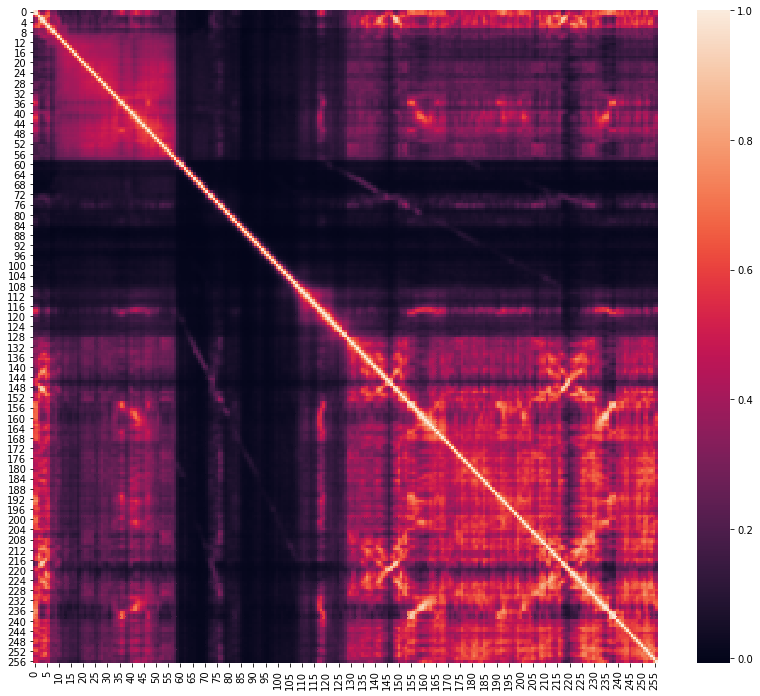

In [29]:
corr = np.corrcoef(train_data.X.T)
print(corr.shape)

plt.figure(figsize=(14,12))
sns.heatmap(corr)
# print(cov.diag())
# i = np.arange(257)


### Normalization for SVM ###

In [30]:
print(Counter(train_data.y_binary))
print(Counter(test_data.y_binary))

Counter({0: 189860, 1: 44525})
Counter({0: 209553, 1: 24832})


In [36]:
mu = np.mean(train_data.X)
sigma2 = np.std(train_data.X)
print(mu, sigma2)

train_data.X = (train_data.X-mu)/sigma2
print(np.mean(train_data.X), np.std(train_data.X))

#############################################
mu = np.mean(test_data.X)
sigma2 = np.std(test_data.X)
print(mu, sigma2)

test_data.X = (test_data.X-mu)/sigma2

print(np.mean(test_data.X), np.std(test_data.X))

0.07591116 0.5681964
1.7115218e-07 0.99999547
0.062335823 0.18055445
6.620309e-07 0.99999857


In [85]:
def evaluate_model(model, dataset, n=10000):
    idx = np.random.randint(0, dataset.y.size, size=n)
    y_pred = model.predict(dataset.X[idx])
    y_true = dataset.y_binary[idx]

    print(confusion_matrix(y_true, y_pred))

    print('accuracy:', accuracy_score(y_true, y_pred))
    precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average='macro')

    print('precision:', precision)
    print('recall:', recall)
    print('fscore:', fscore)
    c = Counter(y_true)
    print('support:', c)
    
    return idx, y_pred, y_true



# model = SVC(kernel='rbf', gamma='auto') # 0.9021
# model = SVC(kernel='poly', degree=3, gamma='auto') # 0.93335
# model = SVC(kernel='poly', degree=2, gamma='auto') # 0.9414
model = SVC(kernel='poly', degree=1, gamma='auto') # 0.9424
# model = SVC(kernel='linear', degree=1, gamma='auto') # 0.9402
# model = SVC(kernel='sigmoid', gamma='auto')

# Train
idx_pos = np.random.choice(np.argwhere(train_data.y_binary == 1).reshape(-1), 2000)
idx_neg = np.random.choice(np.argwhere(train_data.y_binary == 0).reshape(-1), 3000)
idx = np.concatenate((idx_pos, idx_neg))
np.random.shuffle(idx)

c = Counter(train_data.y_binary[idx])
print('Baselines:')
print('weighted random accuracy:', sum(i*i for i in c.values()) / sum(c.values())**2)
print('max random accuracy:', max(c.values()) / sum(c.values()))
print()

model.fit(train_data.X[idx], train_data.y_binary[idx])
# print('Done')

# Evaluation
print('Trainset:')
evaluate_model(model, train_data)

print()
print('TestSet:')
idx, y_pred, y_true = evaluate_model(model, test_data)

Baselines:
weighted random accuracy: 0.52
max random accuracy: 0.6

Trainset:
[[8053   50]
 [ 735 1162]]
accuracy: 0.9215
precision: 0.9375545485818495
recall: 0.8031877856727475
fscore: 0.8505163916012759
support: Counter({0: 8103, 1: 1897})

TestSet:
[[8776  151]
 [ 483  590]]
accuracy: 0.9366
precision: 0.8720279309521071
recall: 0.7664726139983302
fscore: 0.8078170796901938
support: Counter({0: 8927, 1: 1073})


## Jak oceniać modele? jaka miara? ##
## Jak normalizować dane? potrzebne dla SVMa ##

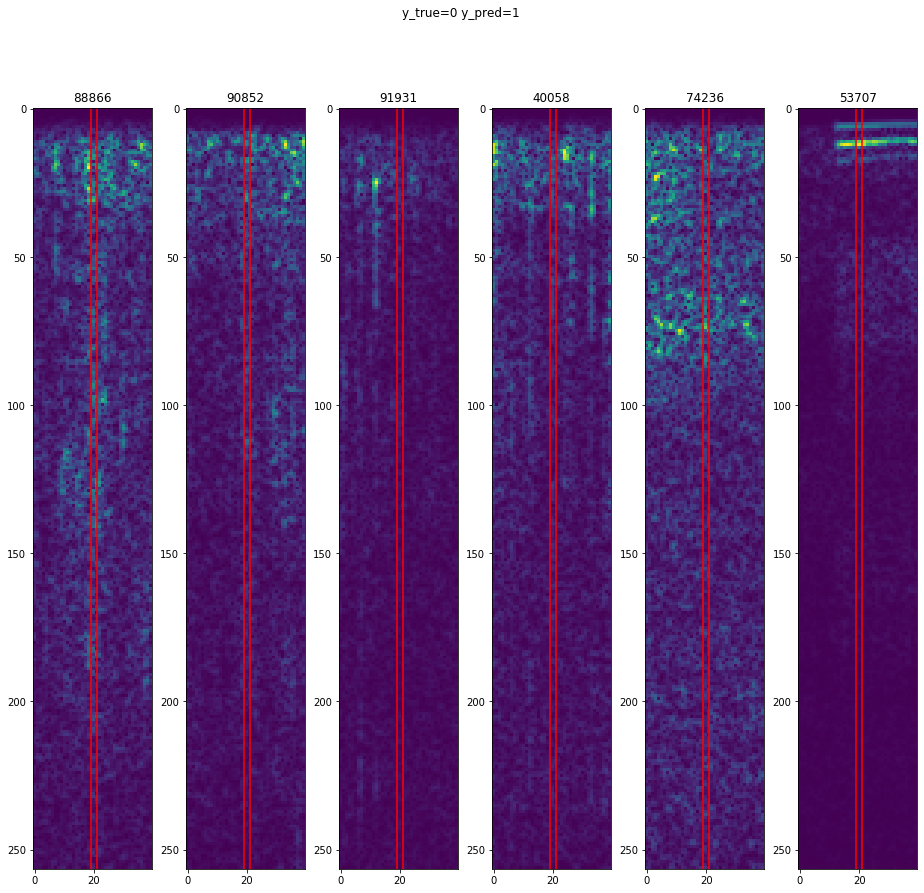

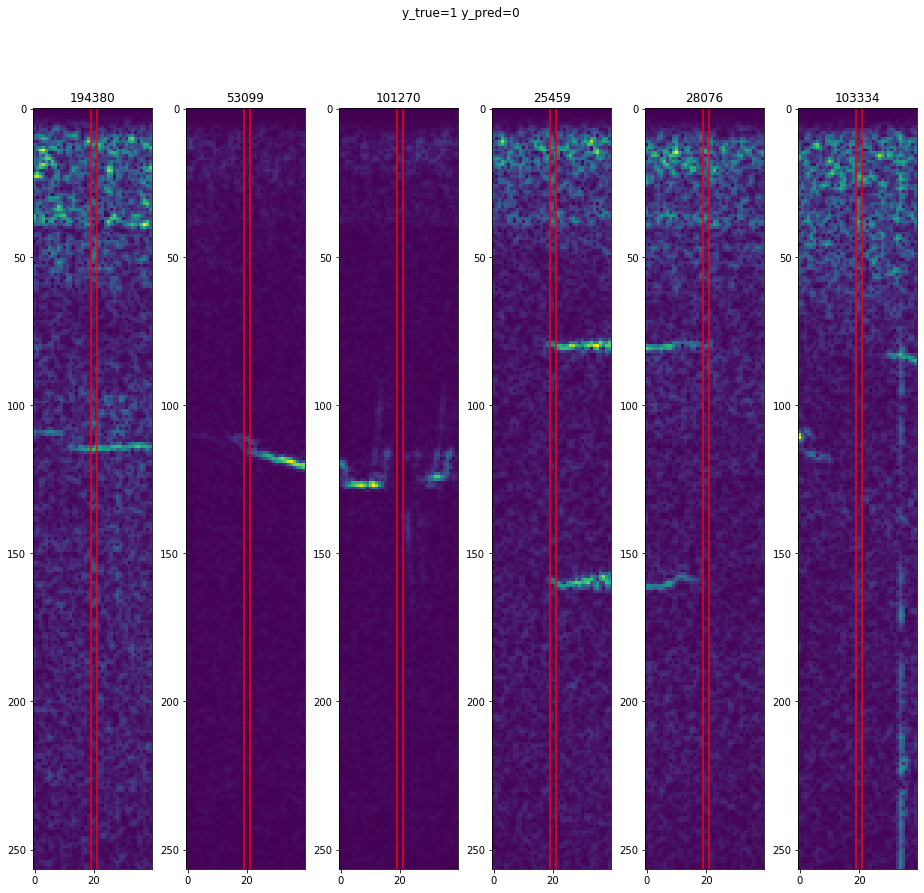

In [88]:
N = 6

################################################
fig, axs = plt.subplots(1, N, figsize=(16, 14))
fig.suptitle('y_true=0 y_pred=1')
for ax, pos in zip(axs, np.random.choice(idx[(y_pred==1) & (y_true == 0)].reshape(-1), N)):
    ax.imshow(test_data.X[pos-20:pos+20].T)
    ax.set_title(f"{pos}")
    ax.axvline(19,color='red')
    ax.axvline(21,color='red')

################################################
fig, axs = plt.subplots(1, N, figsize=(16, 14))
fig.suptitle('y_true=1 y_pred=0')
for ax, pos in zip(axs, np.random.choice(idx[(y_pred==0) & (y_true == 1)].reshape(-1), N)):
    ax.imshow(test_data.X[pos-20:pos+20].T)
    ax.set_title(f"{pos}")
    ax.axvline(19,color='red')
    ax.axvline(21,color='red')
